In [40]:
import sys
from pathlib import Path
from data.data_loader import DataLoader
from wordcloud import WordCloud, STOPWORDS

# Add project root to Python path (go up one level from notebooks/)
project_root = Path.cwd().parent
if str(project_root) not in sys.path:
    sys.path.insert(0, str(project_root))

In [41]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# Set style
sns.set_style("whitegrid")
plt.rcParams['figure.figsize'] = (12, 6)

In [42]:
loader = DataLoader()

Loaded config from c:\Users\matma\Desktop\ITU\NLP\AVDNLP_final_project\configs\config.yaml
Loaded config from c:\Users\matma\Desktop\ITU\NLP\AVDNLP_final_project\configs\config.yaml


In [43]:
original_df = loader.load_data()
df = original_df

In [44]:
df.head()

,news,price_or_not,direction_up,direction_constant,direction_down,pastprice,futureprice,pastnews,futurenews,asset_comparision
0,"april gold down 20 cents to settle at $1,116.1...",1,0,0,1,1,0,0,0,0
1,gold suffers third straight daily decline,1,0,0,1,1,0,0,0,0
2,Gold futures edge up after two-session decline,1,1,0,0,1,0,0,0,0
3,dent research : is gold’s day in the sun comin...,0,0,0,0,0,0,0,1,0
4,"Gold snaps three-day rally as Trump, lawmakers...",1,1,0,0,1,0,0,0,0


In [45]:
# Rename columns for easier handling (optional)
column_renames = {
    'news': 'text',
    'price_or_not': 'price_or_not',
    'direction_up': 'price_up',
    'direction_constant': 'price_constant',
    'direction_down': 'price_down',
    'pastprice': 'past_price_information',
    'futureprice': 'future_price_information',
    'pastnews': 'past_general_information',
    'futurenews': 'future_general_information',
    'asset_comparision': 'asset_comparison'
}

# rename columns if needed
if 'price_or_not' in df.columns:
    df = df.rename(columns=column_renames)

# Define label columns (excluding metadata)
label_columns = [col for col in df.columns if col not in ['Dates', 'URL', 'News']]

# Print basic statistics for label columns
print("\nLabel Distribution:")
display(df[label_columns].describe())


Label Distribution:


,price_or_not,price_up,price_constant,price_down,past_price_information,future_price_information,past_general_information,future_general_information,asset_comparison
count,11412.000000,11412.000000,11412.000000,11412.000000,11412.000000,11412.000000,11412.000000,11412.000000,11412.000000
mean,0.853049,0.415966,0.045829,0.370662,0.819751,0.033386,0.140028,0.007185,0.188398
std,0.354072,0.492909,0.209123,0.483003,0.384411,0.179650,0.347031,0.084465,0.391047
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,1.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000
50%,1.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000
75%,1.000000,1.000000,0.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


## Dataset Overview

In [46]:
# Dataset shape and basic statistics
print(f"Dataset shape: {df.shape}")
print(f"\nMissing values:\n{df.isnull().sum()}")

Dataset shape: (11412, 10)

Missing values:
text                          0
price_or_not                  0
price_up                      0
price_constant                0
price_down                    0
past_price_information        0
future_price_information      0
past_general_information      0
future_general_information    0
asset_comparison              0
dtype: int64


While the original gold news dataset by Sinha and Khandait (2020) provides rich multi-dimensional annotations across nine binary categories, our research objectives focus specifically on comparing fine-tuning methodologies rather than maximizing classification performance across all dimensions. 

Consequently, we strategically narrow our scope to a three-class price direction classification task (up, stable, down), which serves as an appropriate testbed for evaluating the trade-offs between full fine-tuning and parameter-efficient methods like LoRA across different model architectures (BERT vs DistilBERT). This simplification offers several methodological advantages: (1) it reduces task complexity, allowing clearer attribution of performance differences to fine-tuning strategies rather than task-specific factors; (2) it enables faster experimental iteration within our project timeline, permitting multiple training runs with different random seeds for statistical robustness; and (3) it facilitates more interpretable analysis through straightforward metrics like confusion matrices and per-class performance breakdowns. 

To maintain data quality and avoid label ambiguity, we filter the dataset to include only headlines explicitly annotated as price-related (price_or_not=1) and exclude instances with conflicting directional labels (e.g., simultaneous price_up=1 and price_down=1), resulting in approximately 10,000 clean samples. 
This focused approach aligns with our primary goal of understanding how different fine-tuning paradigms affect model efficiency, convergence behavior, and final performance on a well-defined classification task.As our goal is to train a model on classifying price direction we will not need data points which do not have any information on price, so we drop all instances where the price_or_not column is = 0 

In [47]:
# starting size
n0 = len(df)

# drop non-price news
df_price = df.loc[df["price_or_not"] == 1]
n1 = len(df_price)

# drop multi-label instances
direction_cols = ["price_up", "price_constant", "price_down"]
df_clean = df_price.loc[df_price[direction_cols].sum(axis=1) <= 1].copy()
n2 = len(df_clean)

drop_non_price = n0 - n1
drop_multi_label = n1 - n2

print(
    f"Number of rows dropped by excluding non price news: {drop_non_price}.\n"
    f"Number of rows dropped by excluding multi label news: {drop_multi_label}.\n"
    f"Dataset has now {n2} rows."
)


Number of rows dropped by excluding non price news: 1677.
Number of rows dropped by excluding multi label news: 179.
Dataset has now 9556 rows.


## Distribution of Target Variables

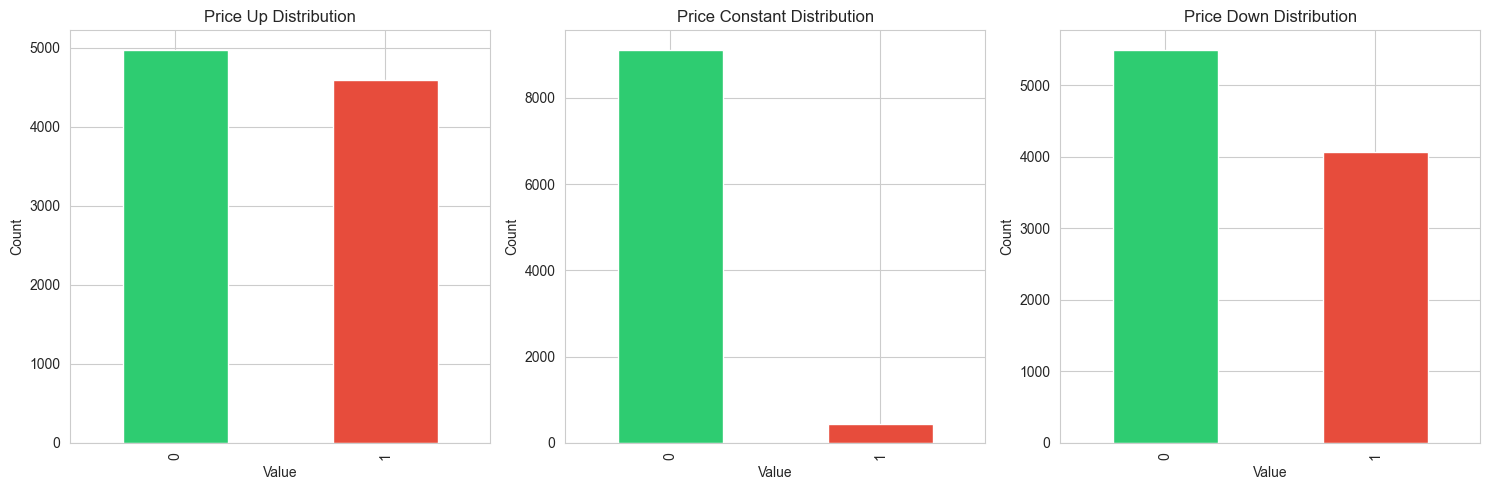

In [48]:
# price direction distribution

fig, axes = plt.subplots(1, 3, figsize=(15, 5))

price_cols = ['price_up', 'price_constant', 'price_down']
for idx, col in enumerate(price_cols):
    if col in df_clean.columns:
        df_clean[col].value_counts().plot(kind='bar', ax=axes[idx], color=['#2ecc71', '#e74c3c'])
        axes[idx].set_title(f'{col.replace("_", " ").title()} Distribution')
        axes[idx].set_xlabel('Value')
        axes[idx].set_ylabel('Count')

plt.tight_layout()
plt.show()

In [49]:
# create single target column
df_clean['price_direction'] = (
    df['price_up'] * 0 + 
    df['price_constant'] * 1 + 
    df['price_down'] * 2
)

df_final = df_clean[['text', 'price_direction']]

## News Text Length Analysis

C:\Users\matma\AppData\Local\Temp\ipykernel_45876\1136288051.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_final['text_length'] = df_final['text'].astype(str).apply(len)


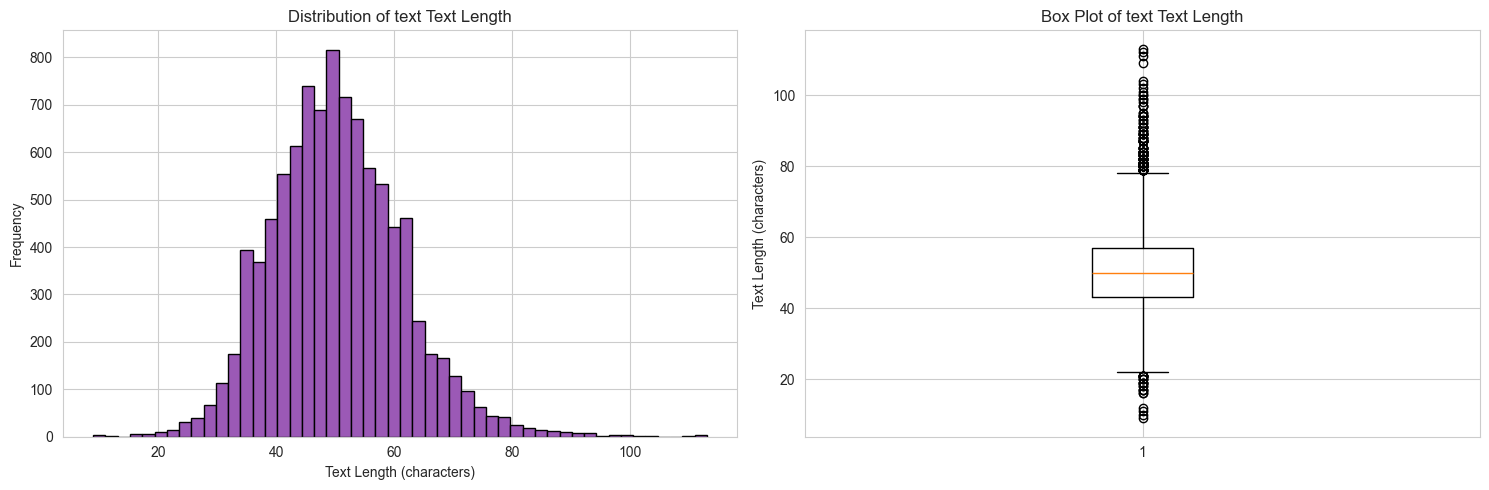

Mean text length: 50.36
Median text length: 50.00


In [50]:
if 'text' in df_final.columns:
    df_final['text_length'] = df_final['text'].astype(str).apply(len)
    
    fig, axes = plt.subplots(1, 2, figsize=(15, 5))
    
    # Histogram
    axes[0].hist(df_final['text_length'], bins=50, color='#9b59b6', edgecolor='black')
    axes[0].set_title('Distribution of text Text Length')
    axes[0].set_xlabel('Text Length (characters)')
    axes[0].set_ylabel('Frequency')
    
    # Box plot
    axes[1].boxplot(df_final['text_length'], vert=True)
    axes[1].set_title('Box Plot of text Text Length')
    axes[1].set_ylabel('Text Length (characters)')
    
    plt.tight_layout() 
    plt.show()
    
    print(f"Mean text length: {df_final['text_length'].mean():.2f}")
    print(f"Median text length: {df_final['text_length'].median():.2f}")

In [51]:
# remove the temporary 'news_length' column
if 'text_length' in df_final.columns:
    df_final.drop(columns=['text_length'], inplace=True)

C:\Users\matma\AppData\Local\Temp\ipykernel_45876\1345253456.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_final.drop(columns=['text_length'], inplace=True)


## Feature Relationships

In [52]:
df_final

,text,price_direction
0,"april gold down 20 cents to settle at $1,116.1...",2
1,gold suffers third straight daily decline,2
2,Gold futures edge up after two-session decline,0
4,"Gold snaps three-day rally as Trump, lawmakers...",0
5,"Dec. gold climbs $9.40, or 0.7%, to settle at ...",0
...,...,...
11406,"February gold up $3.70, or 0.3%, at $1,134.40/oz.",0
11407,gold seen falling from 3-week high this week,2
11409,Gold heading for worst week since November on ...,2
11410,august gold up $7.60 at $878.80 an ounce on nymex,0


In [53]:
# export data to csv
loader.save_csv(df_final)

Saved: C:\Users\matma\Desktop\ITU\NLP\AVDNLP_final_project\data\processed_data.csv


WindowsPath('C:/Users/matma/Desktop/ITU/NLP/AVDNLP_final_project/data/processed_data.csv')

In [54]:
# Sample headlines per class
for class_label in [0, 1, 2]:
    class_name = {0: 'Price Up', 1: 'Price Stable', 2: 'Price Down'}[class_label]
    print(f"\n{class_name}")
    samples = df_final[df_final['price_direction'] == class_label]['text'].sample(n=3, random_state=42)
    for i, text in enumerate(samples, 1):
        print(f"{i}. {text}")


Price Up
1. Weak US Dollar may support Gold, Silver: Angel Commodities
2. dec. gold up $21.30 at $1,779.40/oz in ny
3. gold prices continue gain into asia on political, economic uncertainty

Price Stable
1. gold to trade in 31048-31380 range: achiievers equities
2. Gold prices hold steady as dollar eases
3. gold futures steady ahead of key greek debt talks

Price Down
1. Gold extends losses; silver rebounds by Rs 400 per kg
2. gold slips as fears ease over us-china trade conflict
3. gold prices drop further on heavy stockists offloading


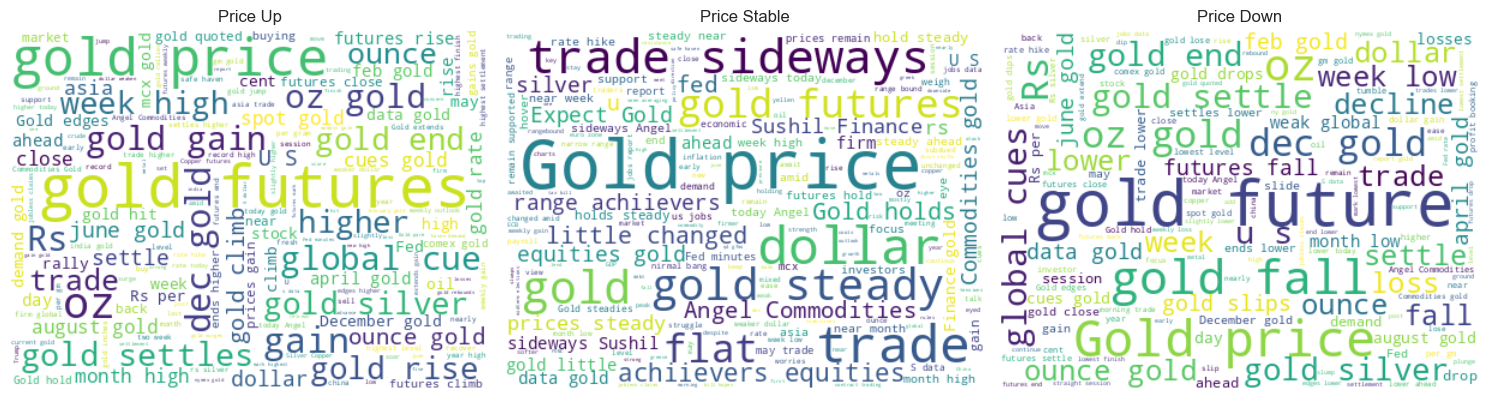

In [55]:
fig, axes = plt.subplots(1, 3, figsize=(15, 4))

for idx, class_label in enumerate([0, 1, 2]):
    class_name = {0: 'Price Up', 1: 'Price Stable', 2: 'Price Down'}[class_label]
    
    # Combine all text for this class
    text_data = ' '.join(df_final[df_final['price_direction'] == class_label]['text'].values)
    
    # Generate word cloud
    wordcloud = WordCloud(width=400, height=300, background_color='white').generate(text_data)
    
    # Plot
    axes[idx].imshow(wordcloud, interpolation='bilinear')
    axes[idx].set_title(class_name)
    axes[idx].axis('off')

plt.tight_layout()
plt.show()

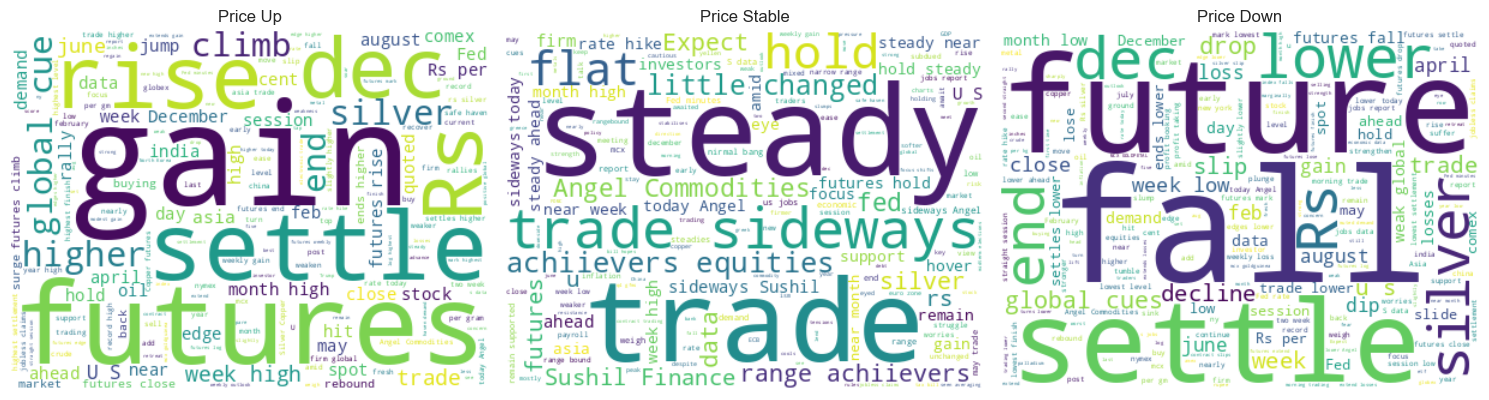

In [56]:
# define custom stopwords
custom_stopwords = set(STOPWORDS)
custom_stopwords.update(['gold', 'Gold', 'GOLD', 'gld', 'price', 'prices', 'dollar', 'oz', 'ounce'])

fig, axes = plt.subplots(1, 3, figsize=(15, 4))

for idx, class_label in enumerate([0, 1, 2]):
    class_name = {0: 'Price Up', 1: 'Price Stable', 2: 'Price Down'}[class_label]
    
    # Combine all text for this class
    text_data = ' '.join(df_final[df_final['price_direction'] == class_label]['text'].values)
    
    # Generate word cloud with stopwords
    wordcloud = WordCloud(
        width=400, 
        height=300, 
        background_color='white',
        stopwords=custom_stopwords
    ).generate(text_data)
    
    # Plot
    axes[idx].imshow(wordcloud, interpolation='bilinear')
    axes[idx].set_title(class_name)
    axes[idx].axis('off')

plt.tight_layout()
plt.show()